## Economics of technology adoption in broadband connectivity

### An analysis of 5G-related filings at the FCC using natural language processing

This is very much work in progress... 


**Summary:** Competition, or the lack thereof, among service providers not only determines economic efficiency but also the rate of adoption of new technologies. In the *broadband connectivity space* many other factors also influence technology adoption. These include local governments, national regulators, utilities,  railroads, owners of cellular towers, workers (in all these companies), contractors and, of course, end users. This analysis is an attempt to use natural language processing tools to quantify the market and institutional complexities in this sphere.


Case in point the FCC's recent rulemaking in [docket 17-84](https://www.fcc.gov/ecfs/search/filings?proceedings_name=17-84&sort=date_disseminated,DESC) on "*Accelerating Wireline Broadband Deployment by Removing Barriers to Infrastructure Investment*". 

There were several issues in the docket 
* **One touch make ready (OTMR):**  Workers from ISP _A_ have to install equipment on a utility pole owned by company *B.* To do that, they need to move/relocate company *C*'s existing equipment (on that pole) to another location. What should each company's obligations be?

* **State and local rules:** The FCC is the main regulator. Some local and state authorities make their own rules in the communication space, such as setting timeframes for utilities to respond to requests for pole access or equipment relocation. Should the FCC pre-empt such rule-making?  
* **Legacy infrastructure:** ISP *A* is upgrading from copper to fibre. What should its obligations be regarding customers in areas where it has no plans to install fibre and wishes to discontinue providing the service? 

### Initial steps
There are over 2000 filings, including over 1300 in just the past 30 days. Some filings have multiple submissions/attachments. Initial attempt to try and understand the variations in the filings (e.g. clusters).

* Focus on formal (standard) filings not express comments.
* Download the files
    * Download relevant CSV (which contains links).
    * Extract the links
    * Download the files (about 450 pdf's out of around 900)
* Extract the text 
    * batch process using PdfToText works for most.
    * OCR (e.g. tesseract) does not work with the scanned pdfs (even after converting to TIFF, JPG)
    * About 380 .txt files 
* Vectorize (TF-IDF) and Visualize
    * Vectorise 2 ways: individual words, and bigrams
    * Visualize in 2 vector spaces: 
        * Vector space: singular values (Latent Semantic Analysis) and principal components.
        * Labels: Hand coded labels (AT&T, Verizon are carriers), and K-means clustering.
 
 ### Documents in the abstract semantic space
 A quick look at the vector space representation. Details appear below. The filers have been hand labeled into five groups: (1) Cable companies, (2) Carriers, (3) FCC's own filings, (4) Municapal or local government (city, county, mayors), and (5) Power utilities.

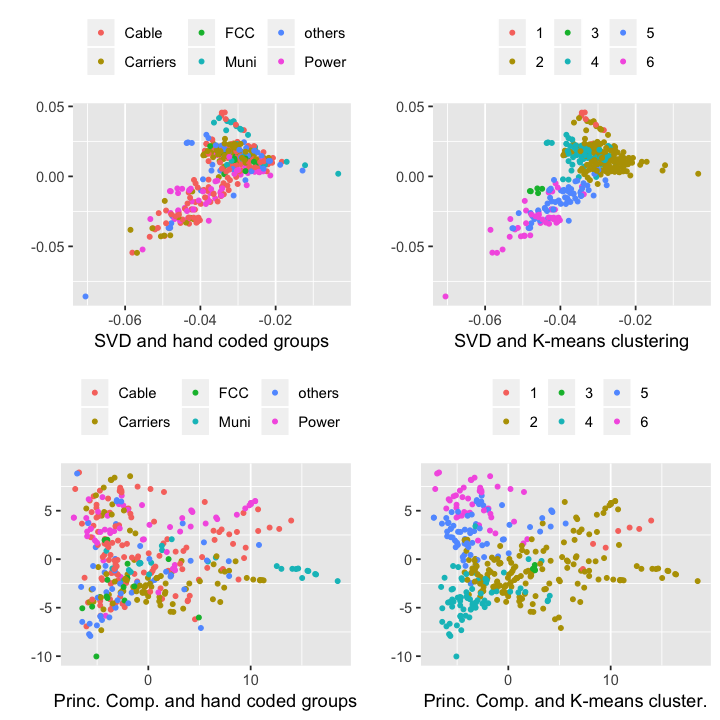

In [18]:
pushViewport(viewport(layout = grid.layout(2,2)));print(p1, vp = viewport(layout.pos.row = 1 , layout.pos.col = 1 ));print(p2, vp = viewport(layout.pos.row = 1 , layout.pos.col = 2 ));print(p3, vp = viewport(layout.pos.row = 2 , layout.pos.col = 1 ));print(p4, vp = viewport(layout.pos.row = 2 , layout.pos.col = 2 ));

Repeating the exercise using **bigrams** should help with the clustering (by adding more semantic context). 

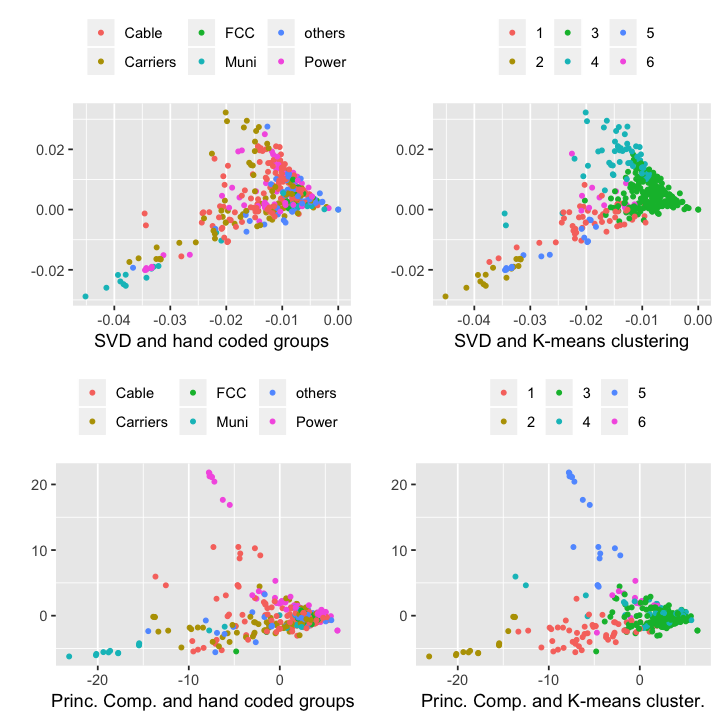

In [22]:
pushViewport(viewport(layout = grid.layout(2,2)));print(p1, vp = viewport(layout.pos.row = 1 , layout.pos.col = 1 ));print(p2, vp = viewport(layout.pos.row = 1 , layout.pos.col = 2 ));print(p3, vp = viewport(layout.pos.row = 2 , layout.pos.col = 1 ));print(p4, vp = viewport(layout.pos.row = 2 , layout.pos.col = 2 ));

## From text to vector spaces 

In [2]:
library(tm)
fcc <- VCorpus(DirSource("./docs/",encoding="UTF-8"), readerControl=list(language="en"))

Loading required package: NLP


In [4]:
del_words= c("commission", "section","counsel", "dear","dortch","washington","secretary")
tdm_fcc <- TermDocumentMatrix(fcc, control = list(
												weighting = function(x) weightTfIdf(x, normalize = T),
												tokenize = "Boost",
												tolower = T,
												removePunctuation = T,
												removeNumbers = T,
												stopwords = c(stopwords("en"),del_words),
												stemming = T))

In [6]:
dim(tdm_fcc)
inspect(tdm_fcc)

[1] 14793   377

<<TermDocumentMatrix (terms: 14793, documents: 377)>>
Non-/sparse entries: 151377/5425584
Sparsity           : 97%
Maximal term length: 155
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)
Sample             :
            Docs
Terms        file171-1.txt file257-1.txt file296-1.txt file321-1.txt
  attach      0.0049458200   0.000000000  0.0003400870   0.001018455
  discontinu  0.0000000000   0.000000000  0.0000000000   0.000000000
  draft       0.0000000000   0.000000000  0.0012904145   0.000000000
  electr      0.0053704236   0.004223458  0.0000000000   0.000000000
  makereadi   0.0007783815   0.000000000  0.0000000000   0.000000000
  otmr        0.0000000000   0.000000000  0.0000000000   0.000000000
  overlash    0.0391503497   0.000000000  0.0000000000   0.000000000
  pole        0.0201588183   0.000000000  0.0004477073   0.000000000
  sean        0.0000000000   0.000000000  0.0000000000   0.000000000
  stoke       0.0000000000   0.000000000  0.0

So we have about 15K terms in 377 documents with a **sparsity** of 97%.  

In [7]:
#function to get the hand coded group name (from row in data file) from document name
stripTxt <- function(x){
	#x<-gsub('[a-zA-Z]+',"",x)
	x<-gsub('(file)|(-[0-9].txt)','',x)
}

#Grab the previously (manually) added group tags by extracting row numbers (stripTxt)
r1<-as.numeric(lapply(Docs(tdm_fcc),stripTxt))
#then use these as row indexes to read the filer names or group from FCC data file.
fccFile<-read.csv("FCC_grouped.csv", header=T)
gp<-fccFile[r1,4] #group tags
filers <- fccFile[r1,3] #filer names

#Idx <- sample(length(r1),10)  a smaller sample for testing 
rm(fccFile)

Reduce the sparsity to 80 percent leaves us with about 500 terms (from the initial 15K). 

In [9]:
tdm_main <- removeSparseTerms(tdm_fcc, sparse = .8)
tdm_main$dimnames$Terms
length(tdm_main$dimnames$Terms)

[1] "“the"          "abil"          "abl"           "abovereferenc"
  [5] "acceler"       "accept"        "access"        "accord"       
  [9] "account"       "across"        "act"           "action"       
 [13] "activ"         "actual"        "adam"          "addit"        
 [17] "address"       "adequ"         "adopt"         "advanc"       
 [21] "advisor"       "advisori"      "affair"        "affect"       
 [25] "agre"          "agreement"     "allow"         "along"        
 [29] "alreadi"       "also"          "altern"        "amend"        
 [33] "america"       "american"      "among"         "analysi"      
 [37] "anoth"         "appli"         "applic"        "approach"     
 [41] "appropri"      "approv"        "april"         "area"         
 [45] "ask"           "associ"        "att"           "attach"       
 [49] "author"        "avail"         "avoid"         "balanc"       
 [53] "barrier"       "base"          "basi"          "believ"       
 [57] "benefit"       "best"          "better"        "broadband"    
 [61] "build"         "burden"        "bureau"        "busi"         
 [65] "cabl"          "call"          "can"           "capac"        
 [69] "carrier"       "case"          "caus"          "cell"         
 [73] "certain"       "cfr"           "chairman"      "challeng"     
 [77] "chang"         "charg"         "chief"         "cite"         
 [81] "citi"          "claim"         "clarifi"       "clear"        
 [85] "comment"       "commission"    "commission’"   "committe"     
 [89] "communic"      "communiti"     "compani"       "compar"       
 [93] "competit"      "complet"       "concern"       "conclus"      
 [97] "condit"        "conduct"       "connect"       "consid"       
[101] "consider"      "consist"       "construct"     "consum"       
[105] "contact"       "continu"       "contract"      "contractor"   
[109] "control"       "copi"          "copper"        "correct"      
[113] "cost"          "creat"         "critic"        "current"      
[117] "custom"        "damag"         "data"          "date"         
[121] "day"           "decis"         "declaratori"   "defin"        
[125] "definit"       "delay"         "demand"        "demonstr"     
[129] "deploy"        "describ"       "design"        "detail"       
[133] "determin"      "develop"       "differ"        "direct"       
[137] "director"      "discuss"       "distribut"     "docket"       
[141] "draft"         "due"           "ecf"           "econom"       
[145] "effect"        "effici"        "effort"        "either"       
[149] "electr"        "electron"      "elimin"        "enabl"        
[153] "encourag"      "end"           "enforc"        "engin"        
[157] "ensur"         "entir"         "entiti"        "equip"        
[161] "essenti"       "establish"     "even"          "everi"        
[165] "evid"          "exampl"        "execut"        "exist"        
[169] "expand"        "expect"        "expens"        "experi"       
[173] "explain"       "express"       "extend"        "face"         
[177] "facil"         "facilit"       "fact"          "fail"         
[181] "far"           "fax"           "fcc"           "fcc’s"        
[185] "feder"         "fee"           "fiber"         "file"         
[189] "final"         "find"          "first"         "focus"        
[193] "follow"        "found"         "function"      "futur"        
[197] "general"       "generat"       "give"          "given"        
[201] "goal"          "govern"        "grant"         "greater"      
[205] "group"         "help"          "hesit"         "high"         
[209] "histor"        "howev"         "identifi"      "impact"       
[213] "implement"     "import"        "impos"         "improv"       
[217] "inc"           "incent"        "includ"        "increas"      
[221] "incumb"        "inde"          "industri"      "inform"       
[225] "infrastructur" "initi"         "inquiri"       "instal"       
[229] "insta

[1] 481

### Dimensionality reduction: 
Principal components first,..

In [10]:
#note transpose (DTM not TDM)
z<-prcomp(t(tdm_main),rank=2,scale=T) #obtain the first 2 principal components

.. followed by singluar value decomposition .. 

In [11]:
x<- svd(tdm_main,2,2) #restrict to 2 singular values
sigma <- x$d 
S <- x$u 
U <-x$v

sigma2<-sigma[1:2] 
S2<-c(S[,1], S[,2])
dim(S2)<-c(dim(tdm_main)[1],2)
U2<-c(U[,1], U[,2])
dim(U2)<-c(dim(tdm_main)[2],2)
U2<-t(U2)

#Now the terms and documents
sigma2Matrix<-c(sigma2[1], 0, 0, sigma2[2])
dim(sigma2Matrix)<-c(2,2)

#scaled concept-document matrix: to see documents in vector space
U2tScaled<-sigma2Matrix %*% U2

In addition to the hand coded labels for different types of filers, use K-means clustering for alternative (and automatic) tagging. 

In [12]:
## Using K-means clustering (and this is obviously in the original space, not the 2D space)
cl <- kmeans(t(tdm_main), 6) #again note transpose (DTM not TDM)

**Note:** The above results should be saved to a file which can be used from other applications, such as plots using D3. 

In [ ]:
newData <- cbind(as.character(filers), as.character(gp), as.numeric(cl$cluster),z$x[,1],z$x[,2], U2tScaled[1,],U2tScaled[2,])
colnames(newData) <- c("filers","group","cluster","PC1", "PC2", "SV1", "SV2")
#write.csv(newData,file="fcc_vizData.csv",row.names=F)

And now the plots using ggplot2

In [13]:
library(ggplot2)
library(grid)
#For Jupyter plot sizing
library(repr) #representaion of strings and bytes from R to other apps
options(repr.plot.width=6, repr.plot.height=6) #default is 7x7 


Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate



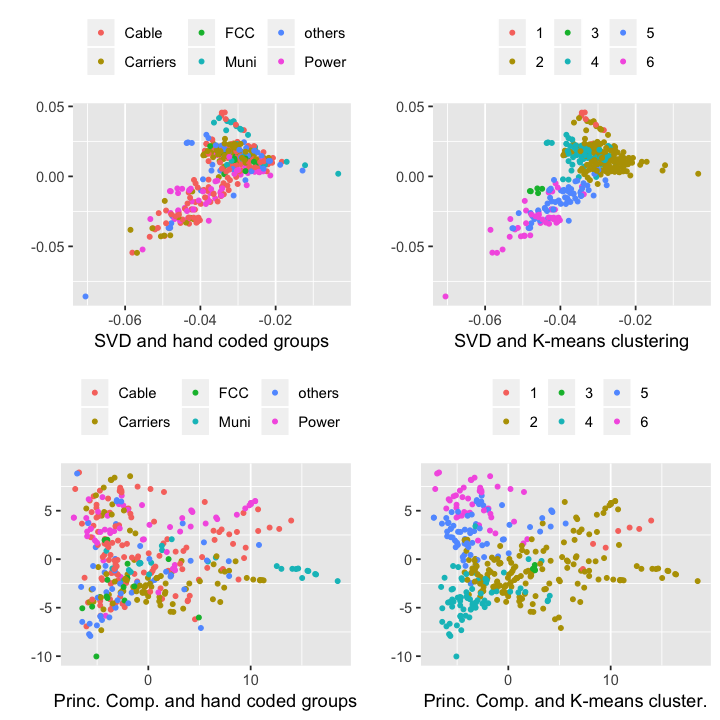

In [19]:
#set up the 2 x 2 grid
numr <-2 ; numc <- 2
pushViewport(viewport(layout = grid.layout(numr,numc)))

layer_point1 <- geom_point(mapping = aes(x=U2tScaled[1,], y=U2tScaled[2,], color = gp),size=1)
p1 <- ggplot() + layer_point1 + labs(x= paste("SVD and hand coded groups"), 
                                y="", 
                                color="") +
     		theme(panel.grid.major.y = element_blank()) +
    	 	theme(legend.position="top")

layer_point1 <- geom_point(mapping = aes(x=U2tScaled[1,], y=U2tScaled[2,], color = as.factor(cl$cluster)),size=1)
p2 <- ggplot() + layer_point1 + labs(x= paste("SVD and K-means clustering"), 
                                y="", 
                                color="") +
     		theme(panel.grid.major.y = element_blank()) +
    	 	theme(legend.position="top")


layer_point1 <- geom_point(mapping = aes(x=z$x[,1],y=z$x[,2], color = gp),size=1)#, 
p3 <- ggplot() + layer_point1 + labs(x= paste("Princ. Comp. and hand coded groups"), 
                                 y="", 
                                 color="") +
      		theme(panel.grid.major.y = element_blank()) +
     	 	theme(legend.position="top")


layer_point1 <- geom_point(mapping = aes(x=z$x[,1],y=z$x[,2], color = as.factor(cl$cluster)),size=1)#, 
p4 <- ggplot() + layer_point1 + labs(x= paste("Princ. Comp. and K-means cluster."), 
                                 y="", 
                                 color="") +
      		theme(panel.grid.major.y = element_blank()) +
     	 	theme(legend.position="top")

print(p1, vp = viewport(layout.pos.row = 1 , layout.pos.col = 1 ))
print(p2, vp = viewport(layout.pos.row = 1 , layout.pos.col = 2 ))
print(p3, vp = viewport(layout.pos.row = 2 , layout.pos.col = 1 ))
print(p4, vp = viewport(layout.pos.row = 2 , layout.pos.col = 2 ))

We repeat the process with now with bigrams.

[1] "a_new"                     "a_pole"                   
  [3] "ability_to"                "able_to"                  
  [5] "about_the"                 "above_captioned"          
  [7] "above_referenced"          "accelerating_wireless"    
  [9] "accelerating_wireline"     "access_to"                
 [11] "advance_notice"            "all_of"                   
 [13] "and_a"                     "and_further"              
 [15] "and_in"                    "and_local"                
 [17] "and_order"                 "and_other"                
 [19] "and_services"              "and_that"                 
 [21] "and_to"                    "any_questions"            
 [23] "are_not"                   "as_a"                     
 [25] "as_the"                    "as_well"                  
 [27] "associated_with"           "at_least"                 
 [29] "at_see"                    "at_t"                     
 [31] "at_the"                    "barriers_to"              
 [33] "based_on"                  "before_the"               
 [35] "being_filed"               "broadband_deployment"     
 [37] "broadband_infrastructure"  "by_a"                     
 [39] "by_removing"               "can_be"                   
 [41] "chairman_pai"              "comments_at"              
 [43] "comments_in"               "comments_of"              
 [45] "commission_has"            "commission_s"             
 [47] "commission_should"         "commission_th"            
 [49] "commission_to"             "communications_commission"
 [51] "consistent_with"           "contact_me"               
 [53] "continue_to"               "d_c"                      
 [55] "declaratory_ruling"        "deployment_and"           
 [57] "deployment_by"             "deployment_of"            
 [59] "discuss_the"               "discussed_the"            
 [61] "do_not"                    "does_not"                 
 [63] "due_to"                    "during_the"               
 [65] "e_g"                       "efforts_to"               
 [67] "electronic_filing"         "ensure_that"              
 [69] "explained_that"            "fcc_gov"                  
 [71] "fcc_rcd"                   "fcc_s"                    
 [73] "federal_communications"    "for_a"                    
 [75] "for_all"                   "for_comment"              
 [77] "for_example"               "from_the"                 
 [79] "further_notice"            "general_counsel"          
 [81] "gn_docket"                 "has_been"                 
 [83] "have_any"                  "have_been"                
 [85] "have_the"                  "hesitate_to"              
 [87] "https_www"                 "id_at"                    
 [89] "if_the"                    "if_you"                   
 [91] "implementation_of"         "in_a"                     
 [93] "in_addition"               "in_its"                   
 [95] "in_order"                  "in_response"              
 [97] "in_the"                    "in_their"                 
 [99] "in_this"                   "in_which"                 
[101] "infrastructure_deployment" "infrastructure_investment"
[103] "investment_wc"             "investment_wt"            
[105] "is_a"                      "is_an"                    
[107] "is_being"                  "is_no"                    
[109] "is_not"                    "is_the"                   
[111] "it_is"                     "legal_advisor"            
[113] "letter_from"               "local_governments"        
[115] "make_ready"                "matter_of"                
[117] "may_be"                    "met_with"                 
[119] "more_than"                 "ms_marlene"               
[121] "must_be"                   "necessary_to"             
[123] "need_for"                  "need_to"                  
[125] "networks_and"              "next_generation"          
[127] "no_accelerating"           "no_at"                    
[129] "not_be"                    

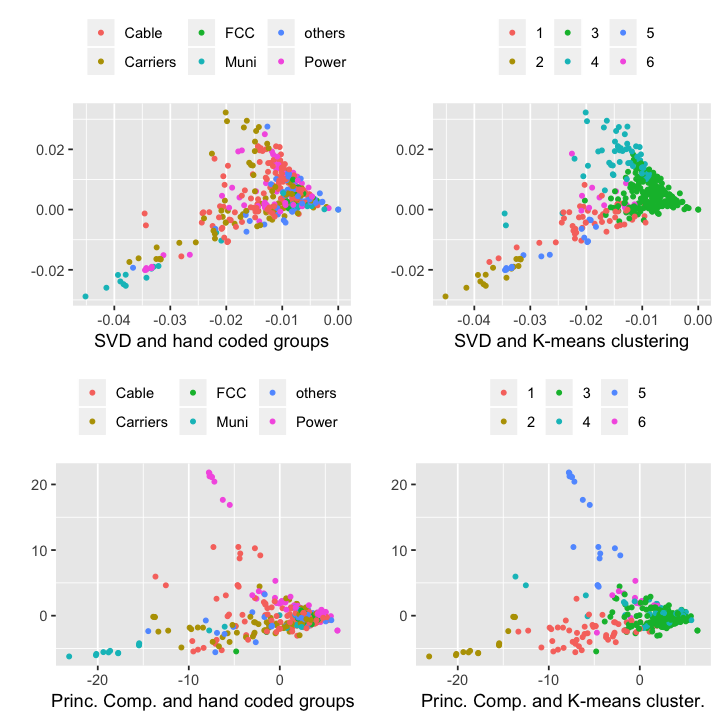

In [21]:
fcc <- VCorpus(DirSource("./tempdocs/bigram/",encoding="UTF-8"), readerControl=list(language="en"))
del_words= c("commission", "section","counsel", "dear","dortch","washington","and_the","by_the","dc_re","dear_ms","docket_no","dortch_on", "dortch_secretary","ex_parte","for_the","h_dortch","marlene_h",       
"ms_dortch","no_dear","notice_of","of_a", "of_the","on_the","secretary_federal","street_sw","th_street","that_the","the_above","the_commission",        
"to_the","washington_dc","wc_docket","with_the")  
tdm_fcc <- TermDocumentMatrix(fcc, control = list(
												weighting = function(x) weightTfIdf(x, normalize = T),
												tokenize = "Boost",
												tolower = T,
												removePunctuation = F,
												removeNumbers = T,
												stopwords = c(stopwords("en"),del_words),
												stemming = F))

tdm_main <- removeSparseTerms(tdm_fcc, sparse = .8)
tdm_main$dimnames$Terms

#Grab the previously (manually) added group tags by extracting row numbers (stripTxt)
r1<-as.numeric(lapply(Docs(tdm_fcc),stripTxt))
#then use these as row indexes to read the filer names or group from FCC data file.
fccFile<-read.csv("FCC_grouped.csv", header=T)
gp<-fccFile[r1,4] #group tags
filers <- fccFile[r1,3] #filer names

#Idx <- sample(length(r1),10)  a smaller sample for testing 
rm(fccFile)


#note transpose (DTM not TDM)
z<-prcomp(t(tdm_main),rank=2,scale=T) #obtain the first 2 principal components

#repeated from above
numr <-2 ; numc <- 2
pushViewport(viewport(layout = grid.layout(numr,numc)))
spar_level = matrix(c(.5),numr,numc,byrow=T) #sparsity level

## Using K-means for grouping (and this is obviously in the original space, not the 2D space)
cl <- kmeans(t(tdm_main), 6) #again note transpose (DTM not TDM)


#Using SVD for visualization
 
x<- svd(tdm_main,2,2) #restrict to 2 singular values
sigma <- x$d 
S <- x$u 
U <-x$v
			
sigma2<-sigma[1:2] #not neccessary with above restriction
S2<-c(S[,1], S[,2])
dim(S2)<-c(dim(tdm_main)[1],2)
#if we had V-Transpose instead, (U here), then would have taken top two rows.
U2<-c(U[,1], U[,2])
dim(U2)<-c(dim(tdm_main)[2],2)
U2<-t(U2)

#Now the terms and documents
sigma2Matrix<-c(sigma2[1], 0, 0, sigma2[2])
dim(sigma2Matrix)<-c(2,2)

#Scaled terms-concept matrix # uncomment when interested in plotting the terms in the  vector space
#S2Scaled<-S2 %*% sigma2Matrix

#scaled concept-document matrix: to see documents in vector space
U2tScaled<-sigma2Matrix %*% U2

#plotting
layer_point1 <- geom_point(mapping = aes(x=U2tScaled[1,], y=U2tScaled[2,], color = gp),size=1)
p1 <- ggplot() + layer_point1 + labs(x= paste("SVD and hand coded groups"), 
                                y="", 
                                color="") +
     		theme(panel.grid.major.y = element_blank()) +
    	 	theme(legend.position="top")

layer_point1 <- geom_point(mapping = aes(x=U2tScaled[1,], y=U2tScaled[2,], color = as.factor(cl$cluster)),size=1)
p2 <- ggplot() + layer_point1 + labs(x= paste("SVD and K-means clustering"), 
                                y="", 
                                color="") +
     		theme(panel.grid.major.y = element_blank()) +
    	 	theme(legend.position="top")


layer_point1 <- geom_point(mapping = aes(x=z$x[,1],y=z$x[,2], color = gp),size=1)#, 
p3 <- ggplot() + layer_point1 + labs(x= paste("Princ. Comp. and hand coded groups"), 
                                 y="", 
                                 color="") +
      		theme(panel.grid.major.y = element_blank()) +
     	 	theme(legend.position="top")


layer_point1 <- geom_point(mapping = aes(x=z$x[,1],y=z$x[,2], color = as.factor(cl$cluster)),size=1)#, 
p4 <- ggplot() + layer_point1 + labs(x= paste("Princ. Comp. and K-means cluster."), 
                                 y="", 
                                 color="") +
      		theme(panel.grid.major.y = element_blank()) +
     	 	theme(legend.position="top")

print(p1, vp = viewport(layout.pos.row = 1 , layout.pos.col = 1 ))
print(p2, vp = viewport(layout.pos.row = 1 , layout.pos.col = 2 ))
print(p3, vp = viewport(layout.pos.row = 2 , layout.pos.col = 1 ))
print(p4, vp = viewport(layout.pos.row = 2 , layout.pos.col = 2 ))

## Supporting programs/sub routines used in the analysis
The first one extracts the relevant URL from the CSV file that can be downloaded using the FCC's api.

In [ ]:
#read in the data set
data <- read.csv(file= "ecfsresults.csv", sep = ",", header=F, skip=1)#, nrows = 10 ) #header is false, num cols data doesn't match num headers

dim(data)
data<-data.frame(data[,c(1,6,9:13)])

colnames(data) <- c("date","filer", "fileURL1", "fileURL2", "fileURL3", "fileURL4", "fileURL5")

#example entry 
#u <- '=HYPERLINK("https://ecfsapi.fcc.gov/file/1041397808761/170413, CTIA Ex Parte.pdf","170413 CTIA Ex Parte.pdf" )'
#out: note "\" added by R before ". Also in this example, url has "," in first part (added by hand, not in actal data set)
#[1] "=HYPERLINK(\"https://ecfsapi.fcc.gov/file/1041397808761/170413, CTIA Ex Parte.pdf\",\"170413 CTIA Ex Parte.pdf\" )"
extractURL <- function(x){
	x<-gsub('\",[[:print:]]*',"",x) #to avoid removing comma inside first URL (if any)
	x <- gsub( '\"',"",x)
	x<- gsub('=HYPERLINK[(]',"",x)
	x<-gsub('[[:space:]]','%20',x)
}
data[,3:6]<-apply(data[,3:6],MARGIN=2,FUN=extractURL)
#save for future use.
write.csv(data, file="fccData.csv", row.names=F)
rm(data)

Read the urls from file created above and download the PDF's into folder

In [ ]:
urlList <- read.csv("fccData.csv", header=T)

num_recs <- dim(urlList)[1] #num records
urls<- c(as.character(urlList[,3]), as.character(urlList[,4]), as.character(urlList[,5]), as.character(urlList[,6]),as.character(urlList[,7]))
#which urls entries exist (fields not blank)
val_link <- which(urls!=""|urls!=NA)

urls <- urls[val_link] #valid links
row_val_link <- val_link %% num_recs #to keep track of which row (i.e.), date, filer.
col_val_link <- (val_link %/% num_recs)+1

#Deterministic download: save original location reference (row,col) as part of filename.
for (i in 1:30){ #change limits as needed. There are many files (about 900).
	Sys.sleep(3)
	if (length(grep(".pdf",urls[i],ignore.case=T)) == 1){	
		download.file(urls[i], timeout=2, destfile = paste0("./tempdocs/file",as.character(row_val_link[i]),"-",as.character(col_val_link[i]),".pdf"))
	}
	else{cat(paste("Skip download for non PDF file in row ", as.character(i), "and URL", urls[i] )) }	
} 

Use **bash** script to extract the text from the PDFs. Called from R or using shell.

In [ ]:
#!/bin/bash

#"modified from http://kenbenoit.net/"
FILES=./tempdocs/*.pdf
for f in $FILES
do
 echo "processing file .."
 pdftotext -enc UTF-8 $f
done

# move txt and pdf to separate dirs
mv ./tempdocs/file*.txt ./docs/
mv ./tempdocs/file*.pdf ./pdf/

#modify file name from *.txt to *-1.txt
#for f in ./docs/*.txt; do mv "$f" "$(echo "$f" | sed s/.txt/-1.txt/)"; done

Assign some labels. This may require some more hand corrections later.

In [ ]:
#FCC 2b 
#Getting the groups right
urlList <- read.csv("fccData.csv", header=T)
#for testing and initial prototyping
##levs<-levels(urlList[,2]) #get filer names for proto

#uncomment this one for main (all lines, not just unique level names)
levs<-as.character(urlList[,2]) #get filer names for proto

#FCC bureaus
gr_gen <- grep("(bureau)|(pai)|(administration)|(counsel)|(commission)",levs, ignore.case=T)
levs[gr_gen] <- "FCC"
#muni local govt
gr_gen <- grep("(cities)|(city)|(mayor)|(counties)|(county)|(town)|(natoa)",levs, ignore.case=T)
levs[gr_gen] <- "Muni"

#Carriers
gr_gen <- grep("(verizon)|(at&t)|(t-mobile)|(sprint)|(ctia)|(wireless)|(crown)|(tower)",levs, ignore.case=T)
levs[gr_gen] <- "Carriers"

#Cable
gr_gen <- grep("(comcast)|(charter)|(centurylink)|(level 3)|(frontier)|(ustelecom)|(telephone)|(cable)|(mobil)|(ncta)|(smart)|(incompas)",levs, ignore.case=T)
levs[gr_gen] <- "Cable"

gr_gen <- grep("(bt amer)|(caltel)|(fiber)|(harris)|(telecom)|(networks)|(communication)",levs, ignore.case=T)
levs[gr_gen] <- "Cable"

#power
gr_gen <- grep("(energy)|(power)|(light)|(electric)|(southern company)",levs, ignore.case=T)
levs[gr_gen] <- "Power"

#others
gr_gen <- grep("(FCC)|(muni)|(Power)|(Cable)|(Workers)|(Carriers)",levs, ignore.case=T)
levs[-gr_gen] <- "others"


#urlList[,2]<-levs
d<-dim(urlList)
newData <- matrix(1:d[1], nrow=d[1],ncol=1)
newData <- cbind(newData,urlList[,1:2])
newData <- cbind(newData,levs)
newData <- cbind(newData,urlList[,3:d[2]])

names(newData)[1]<-"idx"; names(newData)[4]<-"gp" 
rm(urlList)

write.csv(newData, file="FCC_grouped.csv", row.names=F)

Use tidytext to extract ngrams (bigrams used at present)

In [ ]:
library(readr)
library(stringr)
library(magrittr)
library(tidytext)
library(tidyverse)

files<-dir(path="./docs/")
for (f in files){
	txt<-read_lines(file=paste0("./docs/", f, sep=""),) %>% str_c(collapse=1)   
	#txt<- str_c(txt,collapse=1)
	txt <- gsub("([.:;,§¶&]+)|([0-9]+)|([()]+)|([\f])+|([-–+/“”’]+)", " ", txt) 
	
	txt_df <- data_frame(line = 1:length(txt), text=txt)
	txt_df %>% unnest_tokens(word,text)

	ngm <- txt_df %>% unnest_tokens(bigram, text, token = "ngrams", n = 2)	 #change n as required for n-grams

	txt <- gsub(" ", "_",ngm[,"bigram"])
	txt <- gsub("(\")"," ",txt)
	txt <- gsub("(,_)+|([()])","",txt)  
	txt%>% write_lines(,path=paste0("./tempdocs/bigram/",f, sep=""))	
}